# Regresión kernel

Al igual que clasificadores generativos, KDE puede usarse para construir modelos de regresión generativos. En regresión, queremos calcular la esperanza condicional:
$$\mathbb{E}[y\mid\boldsymbol{x},\mathcal{D}]%
=\int y\,p(y\mid\boldsymbol{x},\mathcal{D})\,dy%
=\dfrac{\int y\,p(\boldsymbol{x},y\mid\mathcal{D})\,dy}{\int p(\boldsymbol{x},y\mid\mathcal{D})\,dy}$$
Si usamos una Gaussiana multivariada para $p(\boldsymbol{x},y\mid\mathcal{D})$, obtenemos un modelo equivalente a regresión lineal que resulta bastante limitado; KDE facilita una aproximación más precisa. En particular, el **modelo Nadaraya-Watson** emplea KDE para aproximar la densidad conjunta como:
$$p(\boldsymbol{x},y\mid\mathcal{D})%
\approx\frac{1}{N}\sum_{n=1}^N\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_n)\,\mathcal{K}_h(y-y_n)$$
Así, la esperanza condicional de la salida puede estimarse como una media ponderada de las salidas de los datos:
$$\begin{align*}\mathbb{E}[y\mid\boldsymbol{x},\mathcal{D}]%
&=\dfrac{\dfrac{1}{N}\sum_{n=1}^N\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_n)\overbrace{\int y\,\mathcal{K}_h(y-y_n)\,dy}^{y_n}}{\dfrac{1}{N}\sum_{n=1}^N\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_n)\underbrace{\int \mathcal{K}_h(y-y_n)\,dy}_{1}}\\%
&=\dfrac{\sum_{n=1}^N\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_n)\,y_n}{\sum_{n=1}^N\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_n)}\\%
&=\sum_{n=1}^N y_n\,w_n(\boldsymbol{x})%
\qquad\text{con}\qquad%
w_n(\boldsymbol{x})=\dfrac{\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_n)}{\sum_{n'=1}^N\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_{n'})}
\end{align*}$$

**Ejemplo:** regresión kernel en 1d con un kernel Gaussiano

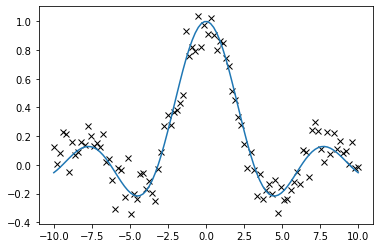

In [4]:
import numpy as np
import matplotlib.pyplot as plt
N_train = 100; noise = 0.1; N_test = 100; np.random.seed(0)
x_train = 10 * (np.linspace(-1, 1, N_train).reshape(-1, 1))
y_train = np.divide(np.sin(np.abs(x_train)), np.abs(x_train))
y_train += noise * np.random.randn(N_train, 1)
x_test = 10 * (np.linspace(-1, 1, N_test).reshape(-1, 1))
y_test = np.divide(np.sin(np.abs(x_test)), np.abs(x_test))
plt.plot(x_train, y_train, 'kx'); plt.plot(x_test, y_test);

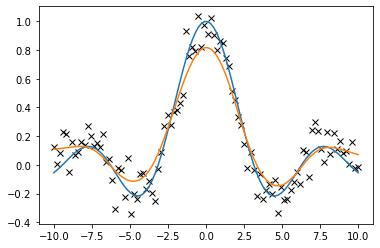

In [5]:
from sklearn.neighbors import KernelDensity
y_pred = np.zeros_like(y_test); w = np.zeros_like(x_train);
kde = KernelDensity(kernel='gaussian', bandwidth=1).fit([[.0]])
for i in np.arange(N_test):
    x = x_test[i].reshape(1, 1)
    w = np.exp(kde.score_samples(x - x_train))
    w = w / w.sum()
    y_pred[i] = np.dot(y_train.T, w)
plt.plot(x_train, y_train, 'kx'); plt.plot(x_test, y_test);
plt.plot(x_test, y_pred);

### Nadaraya-Watson Gaussiano con softmax

Dada una entrada $\boldsymbol{x}$, Nadaraya-Watson regresa una media ponderada de las salidas de los datos. Si se emplea un kernel Gaussiano, es fácil comprobar que los pesos son probabilidades obtenidas mediante normalización softmax de logits que miden la similitud (neg-distancia) entre $\boldsymbol{x}$ y cada dato:
$$\begin{align*}
w_n(\boldsymbol{x})%
&=\dfrac{\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_n)}{\sum_{n'=1}^N\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_{n'})}\\%
&=\dfrac{\dfrac{1}{h^D(2\pi)^{D/2}}\exp\left[-\dfrac{1}{2h^2}\lVert\boldsymbol{x}-\boldsymbol{x}_n\rVert^2\right]}{\sum\limits_{n'=1}^N\dfrac{1}{h^D(2\pi)^{D/2}}\exp\left[-\dfrac{1}{2h^2}\lVert\boldsymbol{x}-\boldsymbol{x}_{n'}\rVert^2\right]}\\%
&=S\left(\left\{-\dfrac{1}{2h^2}\lVert\boldsymbol{x}-\boldsymbol{x}_{n'}\rVert^2\right\}_{n'=1}^N\right)_n%
\end{align*}$$
Esta interpretación de Nadaraya-Watson con kernel Gaussiano se suele emplear en aprendizaje profundo como ejemplo ilustrativo de **mecanismo de atención (no paramétrico).** Las entradas de los datos constituyen un **diccionario** de **claves**, sus salidas los **valores** asociados a las claves, y la entrada $\boldsymbol{x}$ una **consulta (query)**. Los pesos que Nadaraya-Watson otorga a los datos tras la consulta se denominan **pesos de atención**, mientras que sus logits correspondientes reciben el nombre de **scores de atención.** En estos términos, puede decirse que el mecanismo de atención es 
un modelo de regresión condicional que presta mayor atención a las claves que se parecen a la consulta. Los populares **transformers** se basan en el mecanismo de atención principalmente.

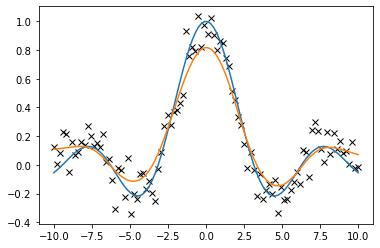

In [6]:
h = 1.0; negsqL2 = lambda x: -0.5 * np.inner(x, x) / h
y_pred = np.zeros_like(y_test); w = np.zeros_like(x_train);
for i in np.arange(N_test):
    z = x_test[i] - x_train
    logits = np.apply_along_axis(negsqL2, 1, z)
    logits -= np.max(logits); w = np.exp(logits); w /= w.sum()
    y_pred[i] = np.dot(y_train.T, w)
plt.plot(x_train, y_train, 'kx'); plt.plot(x_test, y_test);
plt.plot(x_test, y_pred);